https://www.kaggle.com/datasets/manishshah120/facial-expression-recog-image-ver-of-fercdataset

In [2]:
import sys, subprocess
PY = sys.executable
def pip(*args):
    print(">", PY, "-m", "pip", *args)
    subprocess.check_call([PY, "-m", "pip"] + list(args))

print("Usando Python:", PY)

# 1) Limpieza de paquetes que suelen causar el choque
pip("uninstall", "-y",
    "tensorflow", "tensorflow-intel", "tensorflow-directml-plugin",
    "protobuf", "ml-dtypes",
    "numpy", "opencv-python", "opencv-python-headless",
    "pandas", "scipy"
)

# 2) Instalar runtime real de TF para Windows + deps
pip("install", "--upgrade", "tensorflow-intel==2.15.1")

# 3) Fijar versiones compatibles que evitan el bug de protobuf y el choque con NumPy 2.x
pip("install", "--upgrade", "protobuf==3.20.3")
pip("install", "--upgrade", "numpy==1.26.4", "ml-dtypes==0.2.0")

# 4) Plugin de DirectML y OpenCV compatible con NumPy 1.x
pip("install", "--upgrade", "tensorflow-directml-plugin")
pip("install", "--upgrade", "opencv-python-headless==4.10.0.84")  # o opencv-python==4.10.0.84 si necesitas imshow

print("\n=== Reinicia el kernel y luego corre esta verificación ===")


Usando Python: d:\Repositorios\Personal\Reto_2_DeepLearning\.venv\Scripts\python.exe
> d:\Repositorios\Personal\Reto_2_DeepLearning\.venv\Scripts\python.exe -m pip uninstall -y tensorflow tensorflow-intel tensorflow-directml-plugin protobuf ml-dtypes numpy opencv-python opencv-python-headless pandas scipy
> d:\Repositorios\Personal\Reto_2_DeepLearning\.venv\Scripts\python.exe -m pip install --upgrade tensorflow-intel==2.15.1
> d:\Repositorios\Personal\Reto_2_DeepLearning\.venv\Scripts\python.exe -m pip install --upgrade protobuf==3.20.3
> d:\Repositorios\Personal\Reto_2_DeepLearning\.venv\Scripts\python.exe -m pip install --upgrade numpy==1.26.4 ml-dtypes==0.2.0
> d:\Repositorios\Personal\Reto_2_DeepLearning\.venv\Scripts\python.exe -m pip install --upgrade tensorflow-directml-plugin
> d:\Repositorios\Personal\Reto_2_DeepLearning\.venv\Scripts\python.exe -m pip install --upgrade opencv-python-headless==4.10.0.84

=== Reinicia el kernel y luego corre esta verificación ===


In [21]:
!pip install scipy
!pip install scikit-image

  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ------- -------------------------------- 2.4/12.8 MB 12.3 MB/s eta 0:00:01
   ---------------- ----------------------- 5.2/12.8 MB 13.3 MB/s eta 0:00:01
   ------------------------ --------------- 7.9/12.8 MB 13.2 MB/s eta 0:00:01
   --------------------------------- ------ 10.7/12.8 MB 12.9 MB/s eta 0:00:01
   ---------------------------------------  12.6/12.8 MB 12.9 MB/s eta 0:00:01
   ---------------------------------------- 12.8/12.8 MB 11.8 MB/s  0:00:01
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)

   ---------------------------------------- 0/5 [tifffile]
   ---------------------------------------- 0/5 [tifffile]
   ---------------------------------------- 0/5 [tifffile]
   ---------------------------------------- 0/5 [tifffile]
   ---------------------------------------- 0/5 [tifffile]
   ---------------------------------------- 0/5

In [4]:
import sys, numpy, tensorflow as tf
print("Python:", sys.executable)
print("numpy:", numpy.__version__)          # -> 1.26.4
print("TF:", tf.__version__)                # -> 2.15.1
print("protobuf ok")                        # si llegó aquí, ya cargó correctamente
print("DML devices:", tf.config.list_physical_devices('DML'))


Python: d:\Repositorios\Personal\Reto_2_DeepLearning\.venv\Scripts\python.exe
numpy: 1.26.4
TF: 2.10.0
protobuf ok
DML devices: []


In [1]:
import kagglehub
import shutil
import os
import cv2
import warnings
import matplotlib.pyplot as plt
import random as rnd
import numpy as np
import tensorflow as tf

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from skimage.transform import resize
from skimage.io import imread, imshow

from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten,Activation, Conv2D, MaxPooling2D, BatchNormalization, Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop


d:\Repositorios\Personal\Reto_2_DeepLearning\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(tf.__version__)  # debe ser 2.10.0
print(tf.config.list_physical_devices('GPU'))  # Debe mostrar GPU:0 (RTX...)

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
# Intentar memory growth (si no aplica en DML, se ignora)
gpus = tf.config.list_physical_devices('GPU')
for g in gpus:
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass

print("Dispositivos GPU visibles para TF:", tf.config.list_physical_devices('GPU'))

Dispositivos GPU visibles para TF: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# 1. Descarga de la base de datos

In [6]:


# Descargar dataset
path = kagglehub.dataset_download("manishshah120/facial-expression-recog-image-ver-of-fercdataset")
print("Path to dataset files:", path)

# Carpeta destino
dest_path = "imagenes"
os.makedirs(dest_path, exist_ok=True)

# Copiar archivos y carpetas
for item in os.listdir(path):
    source = os.path.join(path, item)
    dest = os.path.join(dest_path, item)

    if os.path.isfile(source):
        shutil.copy(source, dest)
    elif os.path.isdir(source):
        shutil.copytree(source, dest, dirs_exist_ok=True)
        print(f"Carpeta copiada: {item}")

print("Archivos y carpetas copiados a:", dest_path)


Path to dataset files: C:\Users\JLONDTA\.cache\kagglehub\datasets\manishshah120\facial-expression-recog-image-ver-of-fercdataset\versions\1


KeyboardInterrupt: 

# 2. Construcción de los arreglos con las imagenes

In [ ]:
X=[]
Z=[]

X_RGB = []

IMG_SIZE=150

BASE_DIR = 'imagenes/Dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

EXPRESSIONS = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
VALID_EXTENSIONS = ('.jpg', '.jpeg', '.png')

In [5]:
def make_dataset(expression, training=True):
    if training:
        directory = os.path.join(TRAIN_DIR, expression)
    else:
        directory = os.path.join(TEST_DIR, expression)
    
    for img in tqdm(os.listdir(directory)):
        if not img.lower().endswith(VALID_EXTENSIONS):
            print(f"Archivo no válido: {img}")
            continue
        else:
            label = expression
            path = os.path.join(directory, img)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            
            X.append(img)
            X_RGB.append(img_bgr)
            Z.append(label)

# 3. Separación de los conjuntos de train y test

In [6]:
for expression in EXPRESSIONS:
    print(f"Procesando expresión: {expression}")
    make_dataset(expression, training=True)
    make_dataset(expression, training=False)

Procesando expresión: anger


100%|██████████| 491/491 [00:01<00:00, 324.75it/s]


Procesando expresión: disgust


  7%|▋         | 34/493 [00:00<00:01, 336.81it/s]

Archivo no válido: .jovianrc


100%|██████████| 55/55 [00:00<00:00, 328.46it/s]


Procesando expresión: fear


100%|██████████| 528/528 [00:01<00:00, 337.32it/s]


Procesando expresión: happiness


100%|██████████| 879/879 [00:02<00:00, 342.74it/s]


Procesando expresión: neutral


100%|██████████| 626/626 [00:01<00:00, 361.55it/s]


Procesando expresión: sadness


100%|██████████| 594/594 [00:01<00:00, 310.36it/s]


Procesando expresión: surprise


100%|██████████| 416/416 [00:01<00:00, 330.01it/s]


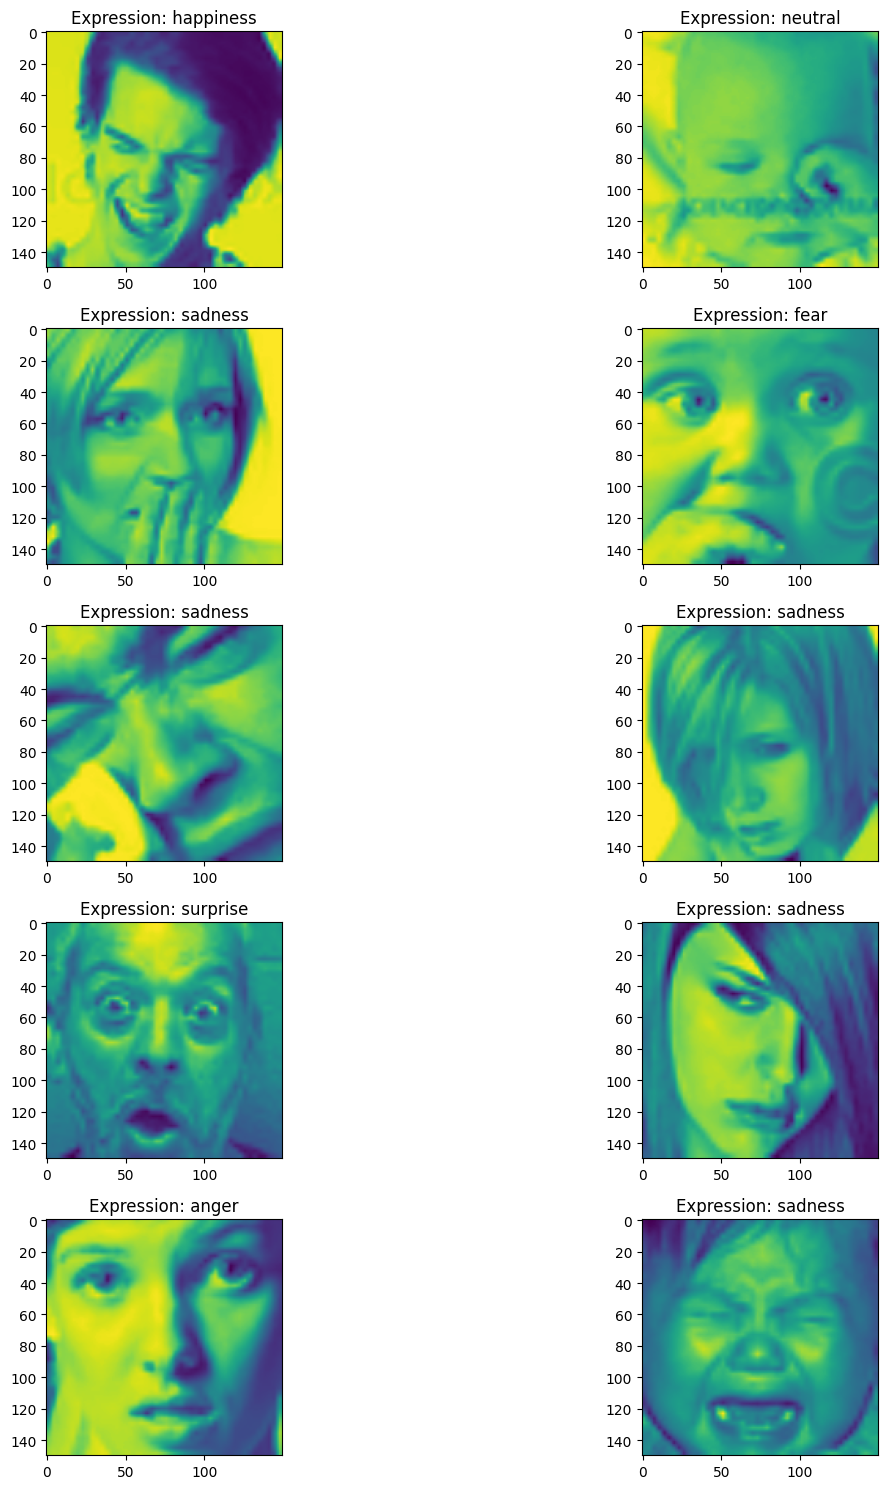

In [7]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rnd.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Expression: '+Z[l])

plt.tight_layout()

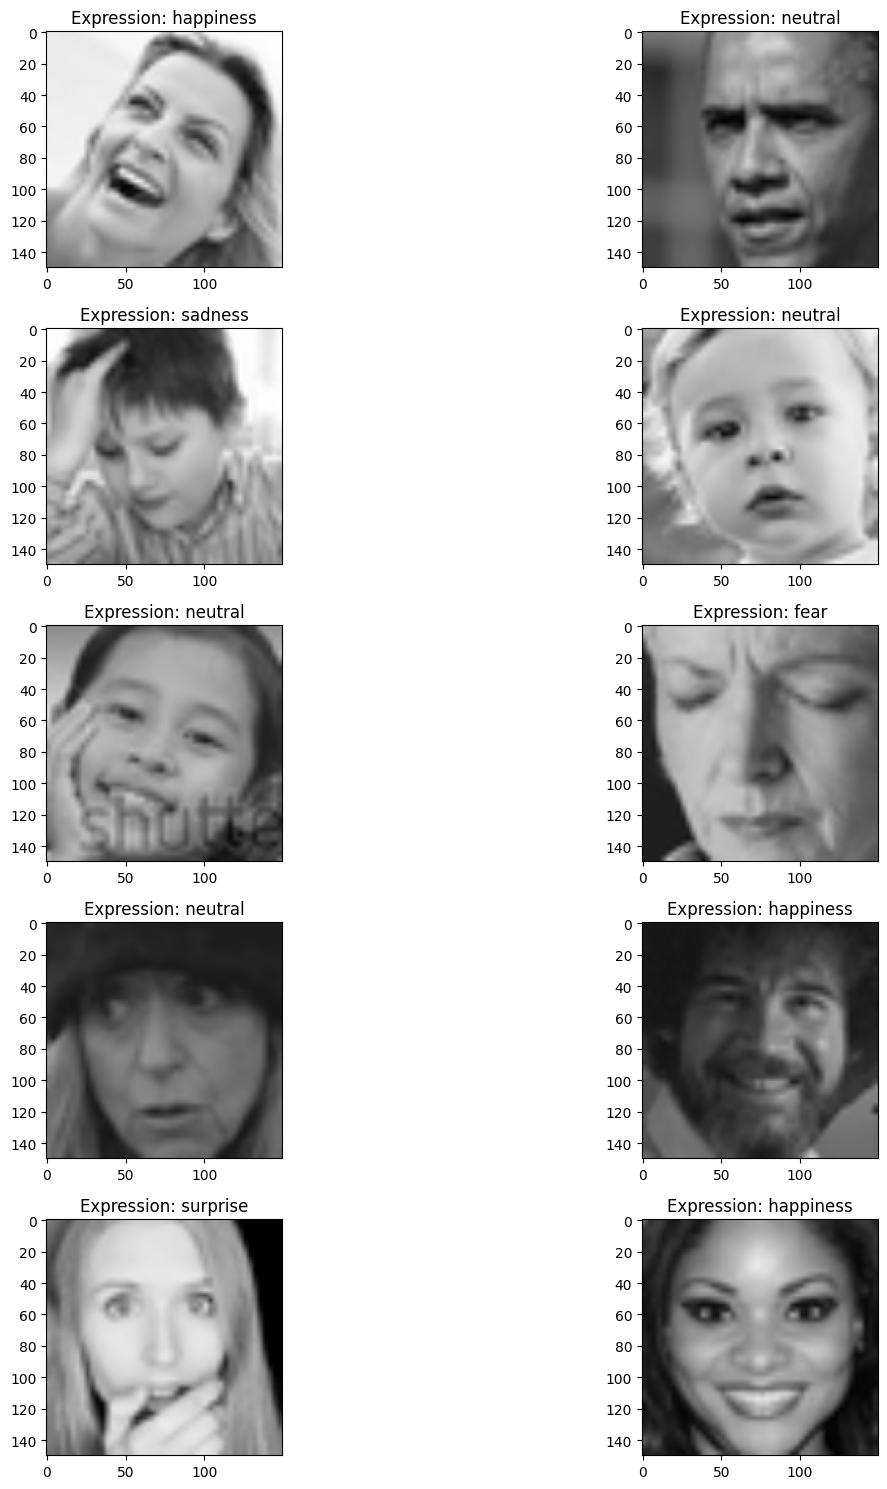

In [8]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rnd.randint(0,len(Z))
        ax[i,j].imshow(X_RGB[l])
        ax[i,j].set_title('Expression: '+Z[l])

plt.tight_layout()

## Procesamiento datasets

Se realiza el LabelEncoding, OneHotEncoding y normalización de las imagenes

In [10]:
le=LabelEncoder()
yi=le.fit_transform(Z) #Convierte a labels encoding
Y=to_categorical(yi,7) # convierte a one-hot encoding

In [11]:
X=np.array(X, dtype="float32") /255
X  = np.expand_dims(X, axis=-1)

In [12]:
X_RGB=np.array(X_RGB, dtype="float32") / 255

In [13]:
print(X.shape)        # esperado: (n, 150, 150, 1)
print(X_RGB.shape)    # esperado: (n, 150, 150, 3)
print(Y.shape)        # esperado: (n, 7)

(35887, 150, 150, 1)
(35887, 150, 150, 3)
(35887, 7)


Se separa el conjunto de datos

In [14]:
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42, stratify=yi
)

In [15]:
x_train_rgb, x_test_rgb, y_train_rgb, y_test_rgb = train_test_split(
    X_RGB, Y, test_size=0.25, random_state=42, stratify=yi
)

In [16]:
np.random.seed(42)
rnd.seed(42)
tf.random.set_seed(42)

# 4. Implementación CNN desde cero

In [20]:
batch_size = 64
epochs = 10

In [21]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(Conv2D(filters =128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(7, activation = "softmax"))

In [22]:
model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      832       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 96)        27744     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 37, 37, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 37, 37, 128)       110720    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 18, 18, 128)     

In [24]:
History = model.fit(x_train,y_train, batch_size=batch_size,
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1)

Epoch 1/10
421/421 [==============================] - 23s 53ms/step - loss: 1.6730 - accuracy: 0.3299 - val_loss: 1.5147 - val_accuracy: 0.4126
Epoch 2/10
421/421 [==============================] - 22s 52ms/step - loss: 1.3651 - accuracy: 0.4761 - val_loss: 1.3312 - val_accuracy: 0.4883
Epoch 3/10
421/421 [==============================] - 22s 52ms/step - loss: 1.1891 - accuracy: 0.5451 - val_loss: 1.2459 - val_accuracy: 0.5252
Epoch 4/10
421/421 [==============================] - 22s 52ms/step - loss: 1.0263 - accuracy: 0.6165 - val_loss: 1.2154 - val_accuracy: 0.5450
Epoch 5/10
421/421 [==============================] - 22s 52ms/step - loss: 0.8312 - accuracy: 0.6919 - val_loss: 1.3060 - val_accuracy: 0.5439
Epoch 6/10
421/421 [==============================] - 22s 52ms/step - loss: 0.5811 - accuracy: 0.7903 - val_loss: 1.5217 - val_accuracy: 0.5437
Epoch 7/10
421/421 [==============================] - 22s 52ms/step - loss: 0.3584 - accuracy: 0.8743 - val_loss: 1.8656 - val_accuracy:

In [25]:
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

281/281 [==============================] - 2s 8ms/step


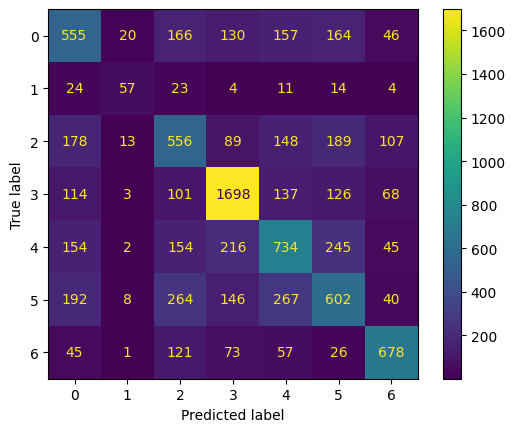

In [26]:
ConfusionMatrixDisplay(confusion_matrix(np.argmax(y_test,axis=1),pred_digits)).plot()
plt.show()

In [27]:
print(classification_report(np.argmax(y_test,axis=1),pred_digits))

              precision    recall  f1-score   support

           0       0.44      0.45      0.44      1238
           1       0.55      0.42      0.47       137
           2       0.40      0.43      0.42      1280
           3       0.72      0.76      0.74      2247
           4       0.49      0.47      0.48      1550
           5       0.44      0.40      0.42      1519
           6       0.69      0.68      0.68      1001

    accuracy                           0.54      8972
   macro avg       0.53      0.51      0.52      8972
weighted avg       0.54      0.54      0.54      8972



In [ ]:
# ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

In [28]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

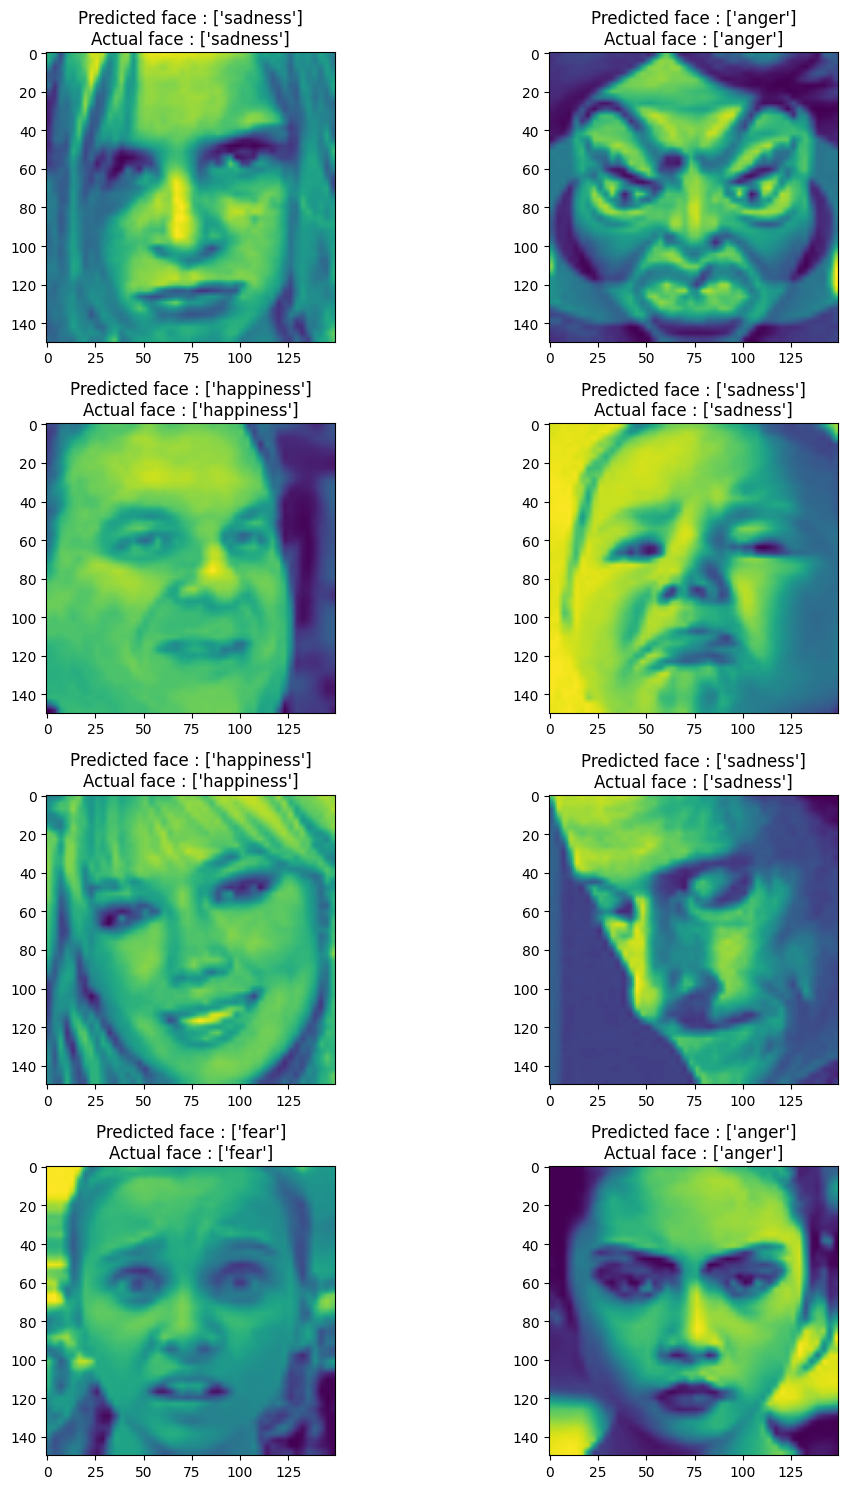

In [29]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        predict_max=np.argmax(y_test,axis=1)
        ax[i,j].set_title("Predicted face : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual face : "+str(le.inverse_transform([predict_max[prop_class[count]]])))
        plt.tight_layout()
        count+=1

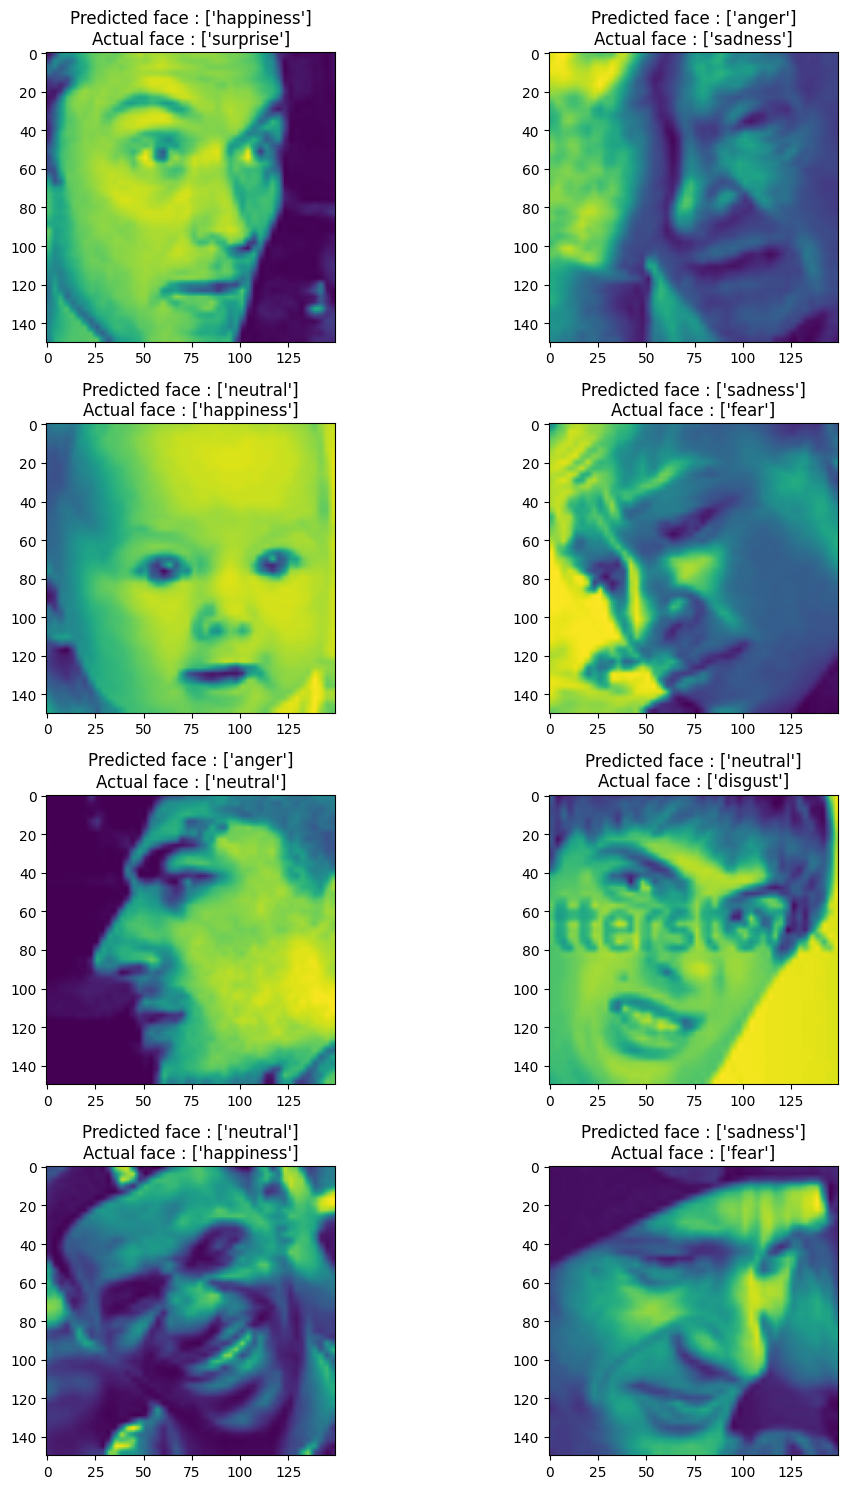

In [30]:
#warnings.filterwarnings('always')
#warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        predict_max=np.argmax(y_test,axis=1)
        ax[i,j].set_title("Predicted face : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual face : "+str(le.inverse_transform([predict_max[mis_class[count]]])))
        plt.tight_layout()
        count+=1

In [31]:
#impiar memoria antes del Fine-Tune
import gc
from keras import backend as K

K.clear_session()  # libera el grafo de la CNN en gris
# liberar tensores de la fase 1 (gris)
del x_train, x_test, y_train, y_test, X
gc.collect()


46

# Transfer Learning y Fine Tunning

### *Vamos a utilizar el modelo preentrenado Restnet*

In [32]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from keras.applications.resnet import ResNet50
from keras.applications.mobilenet_v2 import MobileNetV2


In [33]:
model_FT = Sequential()

model_FT.add(MobileNetV2(include_top=False, pooling='avg', weights='imagenet'))
model_FT.add(Flatten())
model_FT.add(BatchNormalization())
model_FT.add(Dense(512, activation='relu'))
model_FT.add(Dropout(0.3))
model_FT.add(BatchNormalization())
model_FT.add(Dense(256, activation='relu'))
model_FT.add(Dropout(0.2))
model_FT.add(BatchNormalization())
model_FT.add(Dense(7, activation='softmax'))

model_FT.layers[0].trainable = False

In [34]:
from keras.optimizers import Adam
model_FT.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['accuracy'])
model_FT.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2

In [35]:
batch_size = 16  
epochs = 10

In [36]:
History = model_FT.fit(x_train_rgb, y_train_rgb,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_test_rgb, y_test_rgb),
                        verbose=1,
                        workers=0,
                        use_multiprocessing=False)

: 

In [ ]:
import matplotlib.pyplot as plt
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

In [ ]:
accuracy_score(np.argmax(y_test,axis=1),pred_digits)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
target_names = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
print(classification_report(np.argmax(y_test,axis=1), pred_digits, target_names=target_names))

In [ ]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower :"+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax(y_test[mis_class[count]])])))
        plt.tight_layout()
        count+=1